In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

import pathlib

import matplotlib.pyplot as plt

from tensorflow.keras import layers

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

In [3]:
#paths
global_path = os.path.join('/content/drive/My Drive/Dog_breeds/')
images_dir = os.path.join(global_path)
images_dir = pathlib.Path(images_dir)

In [4]:
image_count = len(list(images_dir.glob('*/*.jpg')))
print(image_count)

20590


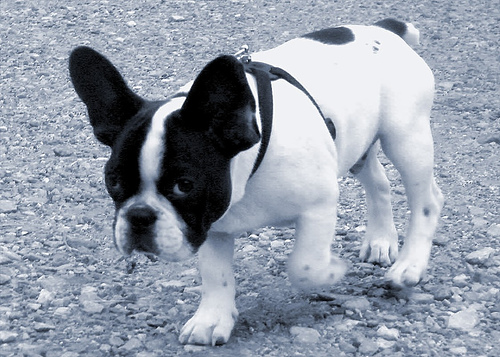

In [5]:
i = 0
j = 0
path = list(images_dir.glob('*'))
file = list(path[i].glob('*/'))
PIL.Image.open(str(file[j]))

In [6]:
batch_size = 512
image_size=(160, 160)


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  images_dir,
  validation_split=0.2,
  subset="training",
  seed = 10,
  image_size=image_size,
  batch_size=batch_size)

Found 20590 files belonging to 120 classes.
Using 16472 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  images_dir,
  validation_split=0.2,
  subset="validation",
  seed=10,
  image_size=image_size,
  batch_size=batch_size)

Found 20590 files belonging to 120 classes.
Using 4118 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t

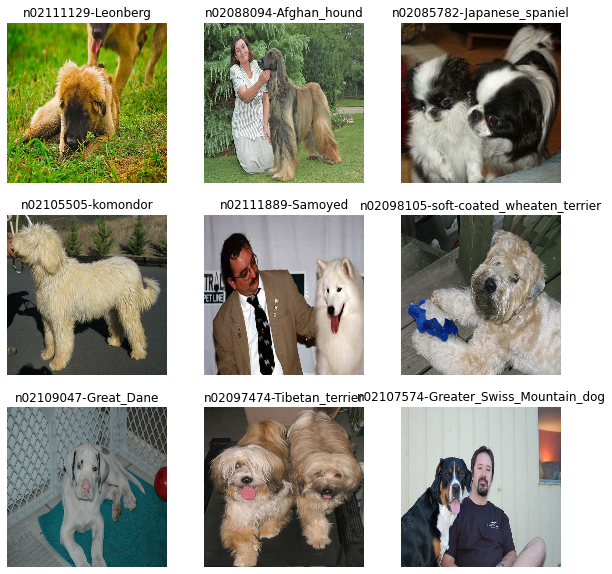

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
IMG_SHAPE = image_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [12]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(512, 5, 5, 1280)


In [13]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(512, 1280)


In [15]:
len(class_names)

120

In [16]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation ='softmax')

In [17]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
len(model.trainable_variables)

2

In [22]:
history = model.fit(train_ds,
                    epochs=33,
                    validation_data=val_ds)

Epoch 1/33
33/33 [==============================] - 331s 10s/step - loss: 4.1894 - accuracy: 0.7271 - val_loss: 4.2118 - val_accuracy: 0.6969
Epoch 2/33
33/33 [==============================] - 331s 10s/step - loss: 4.1777 - accuracy: 0.7302 - val_loss: 4.2019 - val_accuracy: 0.7025
Epoch 3/33
33/33 [==============================] - 334s 10s/step - loss: 4.1661 - accuracy: 0.7411 - val_loss: 4.1916 - val_accuracy: 0.7088
Epoch 4/33
33/33 [==============================] - 343s 10s/step - loss: 4.1551 - accuracy: 0.7482 - val_loss: 4.1840 - val_accuracy: 0.7139
Epoch 5/33
33/33 [==============================] - 345s 10s/step - loss: 4.1484 - accuracy: 0.7515 - val_loss: 4.1772 - val_accuracy: 0.7181
Epoch 6/33
33/33 [==============================] - 332s 10s/step - loss: 4.1396 - accuracy: 0.7567 - val_loss: 4.1714 - val_accuracy: 0.7207
Epoch 7/33
33/33 [==============================] - 330s 10s/step - loss: 4.1317 - accuracy: 0.7627 - val_loss: 4.1654 - val_accuracy: 0.7246
Epoch 

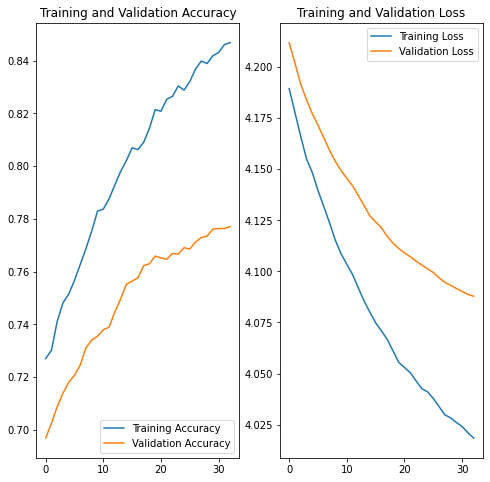

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(33)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [95]:
i = 10
j = 130
path = list(images_dir.glob('*'))
file = list(path[i].glob('*/'))
img = keras.preprocessing.image.load_img(
    file[j], target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to " f'{class_names[np.argmax(score)]}' " with a " f'{100 * np.max(score)}' "percent confidence."
)

PIL.Image.open(str(file[j]))

Output hidden; open in https://colab.research.google.com to view.

In [92]:
def show_webimage_pred(j):
  for i in range(j):
    webimages_path = os.path.join('/content', 'drive' , 'My Drive', 'Binary classification', 'webimages')
    webimages_path = pathlib.Path(webimages_path)
    file = list(webimages_path.glob('*/'))
    img = keras.preprocessing.image.load_img(
        file[i], target_size= image_size
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to " f'{class_names[np.argmax(score)]}' " with a " f'{100 * np.max(score)}' "percent confidence."
    )

    plt.imshow(PIL.Image.open(str(file[i])))
    plt.show()

This image most likely belongs to n02111500-Great_Pyrenees with a 1.3010578230023384percent confidence.


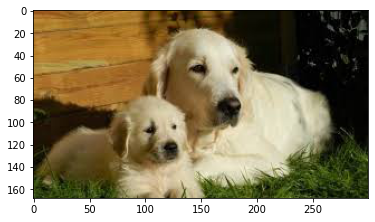

This image most likely belongs to n02099601-golden_retriever with a 2.22617220133543percent confidence.


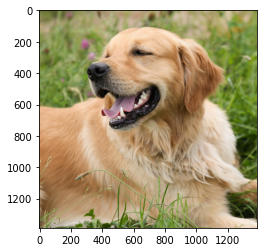

This image most likely belongs to n02110185-Siberian_husky with a 2.2138595581054688percent confidence.


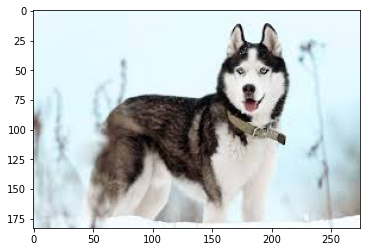

This image most likely belongs to n02086079-Pekinese with a 1.294661033898592percent confidence.


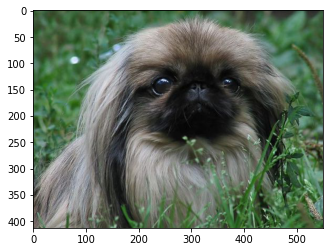

This image most likely belongs to n02106662-German_shepherd with a 2.230176143348217percent confidence.


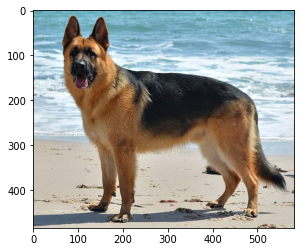

This image most likely belongs to n02106662-German_shepherd with a 2.222551591694355percent confidence.


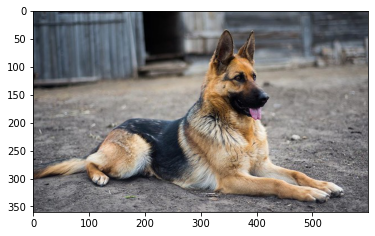

This image most likely belongs to n02086910-papillon with a 2.2176306694746017percent confidence.


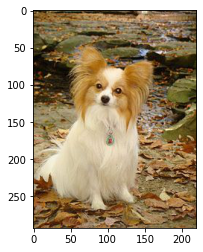

This image most likely belongs to n02113712-miniature_poodle with a 1.9262893125414848percent confidence.


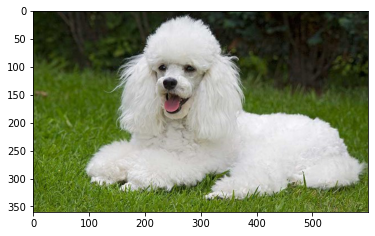

This image most likely belongs to n02086910-papillon with a 2.2276196628808975percent confidence.


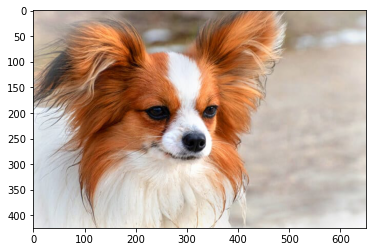

This image most likely belongs to n02113978-Mexican_hairless with a 1.4398747123777866percent confidence.


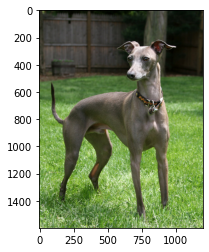

This image most likely belongs to n02110958-pug with a 2.230766788125038percent confidence.


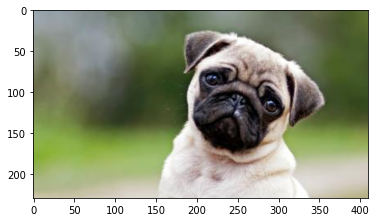

In [97]:
show_webimage_pred(11)